In [1]:
import pandas as pd
import geopandas as gpd
#import db_dtypes
import matplotlib.pyplot as plt 
import folium
from shapely.geometry import Point, Polygon, LineString
from shapely import intersection
%matplotlib inline


C:\Users\abreunig\AppData\Local\Temp\2\ipykernel_11608\1502177323.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:

shapes = gpd.read_file("vexcel_selection.shp")

In [3]:
# Get centroid locations
bounds = shapes.total_bounds
centroid_x = (bounds[0] + bounds[2]) / 2
centroid_y = (bounds[1] + bounds[3]) / 2
print(centroid_x, centroid_y)

-122.62550925157649 38.236679420085196


In [4]:

crs = shapes.crs

# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(shapes).add_to(map)
map

In [5]:
shapes.head()   


,id,geometry
0,1,"POLYGON ((-122.62555 38.23676, -122.62553 38.2..."
1,2,"POLYGON ((-122.62548 38.23672, -122.62545 38.2..."


In [6]:

data_overlaps=gpd.GeoDataFrame(columns=['id','geometry'],geometry='geometry', crs=shapes.crs)

for index, row in shapes.iterrows():
    row_geom = row.geometry
    row_id = row.id
    data_temp1 = shapes.loc[shapes.id!=row_id]
    print(f'data temp: {data_temp1.id}')
    # check if intersection occured
    overlaps=data_temp1[data_temp1.geometry.overlaps(row.geometry)]['id'].tolist()


    if len(overlaps)>0:
        temp_list=[]


        # compare the area with threshold

        
        for y in overlaps:
            overlap_geom = shapes.loc[shapes.id==y, 'geometry'].values[0]
            intersect_geom = intersection(row_geom, overlap_geom)
            #temp_area=gpd.overlay(,shapes.loc[shapes.id==row.id,],how='intersection')

            #data_overlaps=gpd.GeoDataFrame(pd.concat([temp_area,data_overlaps],ignore_index=True),crs=shapes.crs)
            #data_overlaps = pd.concat([data_overlaps,temp_area],ignore_index=True)

    break
# data_overlaps.to_file('overlaps.shp')
# # get unique of list id
# data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
# #data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
# #data_overlaps=data_overlaps.drop_duplicates('sorted')
# #data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

data temp: 1    2
Name: id, dtype: int64


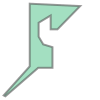

In [7]:
intersect_geom

In [8]:
# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(intersect_geom).add_to(map)
#folium.GeoJson(g3).add_to(map)
map

In [9]:
fixed_geom = shapes.symmetric_difference(intersect_geom)
fixed_geom

0    POLYGON ((-122.62553 38.23678, -122.62549 38.2...
1    POLYGON ((-122.62545 38.23674, -122.62538 38.2...
dtype: geometry

In [11]:
#geoseries to geodataframe
fixed_geom = gpd.GeoDataFrame(geometry=fixed_geom)
fixed_geom

,geometry
0,"POLYGON ((-122.62553 38.23678, -122.62549 38.2..."
1,"POLYGON ((-122.62545 38.23674, -122.62538 38.2..."


In [12]:
fixed_geom = fixed_geom.reset_index()
fixed_geom

,index,geometry
0,0,"POLYGON ((-122.62553 38.23678, -122.62549 38.2..."
1,1,"POLYGON ((-122.62545 38.23674, -122.62538 38.2..."


In [13]:

# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(fixed_geom).add_to(map)

map

#fixed_geom.to_file('fixed.shp')

In [14]:
from shapely.ops import unary_union

In [15]:
fixed_reproj = fixed_geom.to_crs(epsg=32610)
fixed_reproj.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
fixed_union = fixed_reproj.unary_union

#fixed_geom_buff = new.buffer(50).buffer(-50)

In [17]:
fixed_union_gdf = gpd.GeoDataFrame(geometry=[fixed_union], crs=32610)
fixed_union_gdf

,geometry
0,"MULTIPOLYGON (((532784.949 4232144.541, 532775..."


In [18]:
fixed_union_gdf['geometry'] = fixed_union_gdf['geometry'].buffer(50)
fixed_union_gdf['geometry'] = fixed_union_gdf['geometry'].buffer(-50)

In [19]:
# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(fixed_union_gdf).add_to(map)
map

In [ ]:
fixed_union_gdf = fixed_union_gdf.to_crs(4326)

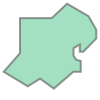

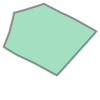

In [33]:
canidate_fixed_geom = shapes.iloc[0].geometry
canidate_union = fixed_union_gdf.iloc[0].geometry
display(canidate_fixed_geom)
display(canidate_union)

In [34]:
from shapely import difference

In [35]:

split = difference(canidate_union, canidate_fixed_geom)


In [36]:
# OpenStreetMap
map = folium.Map(location=[centroid_y, centroid_x], tiles="OpenStreetMap", zoom_start=25)
folium.GeoJson(split).add_to(map)
map